In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
!pip install awscli

In [4]:
#!pip install -r '/content/drive/My Drive/mnist_fashion/requirements.txt'
!pip install -r requirements.txt

     |████████████████████████████████| 43.4 MB 954 kB/s eta 0:00:01     |████████████████████████        | 32.5 MB 1.0 MB/s eta 0:00:11


In [5]:
!pip install quilt3

In [7]:
import quilt3 as t4

t4.Package.install("aleksey/fashion_mnist", registry="s3://quilt-example", dest=".")
#from keras.datasets import fashion_mnist
#(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


Loading manifest: 100%|██████████| 3/3 [00:00<00:00, 3472.11entries/s]

In [8]:
!mv "fashion_mnist/fashion-mnist_train.csv" "fashion-mnist_train.csv"
!rm -rf "quilt/"

mv: fashion_mnist/fashion-mnist_train.csv: No such file or directory


In [9]:
import numpy as np
import pandas as pd

data_train = pd.read_csv('fashion-mnist_train.csv')
data_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
sorted(data_train.label.unique())


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

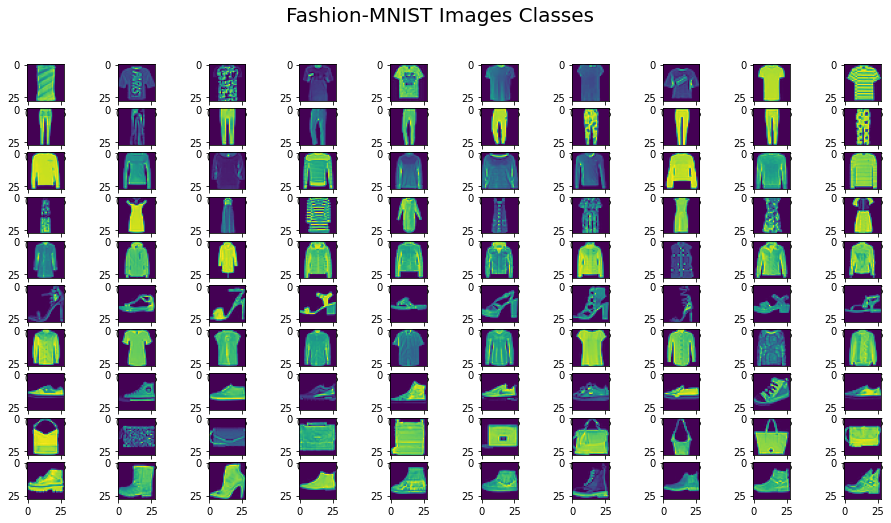

In [11]:
%matplotlib inline

labels = sorted(data_train.label.unique())
n_samples = 10

import matplotlib.pyplot as plt
fig, axarr = plt.subplots(len(labels), n_samples, figsize=(16, 8))

for j, label in enumerate(labels):
    for k, img_arr in enumerate(data_train.query("label == @label").sample(n_samples, random_state=42)\
                                    .values[:, 1:].reshape((n_samples, 28, 28))):
        axarr[j][k].imshow(img_arr)

fig.suptitle("Fashion-MNIST Images Classes", fontsize=20)
pass

In [12]:
img_class_key = {
    0: 't-shirt',
    1: 'pants',
    2: 'pullover',
    3: 'dress',
    4: 'coat',
    5: 'sandal',
    6: 'shirt',
    7: 'sneakers',
    8: 'handbag',
    9: 'boot'
}

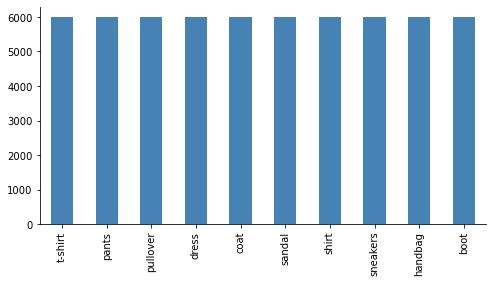

In [13]:
import seaborn as sns
label_counts = data_train['label'].value_counts()
label_counts.index = img_class_key.values()
label_counts.plot.bar(color='steelblue', figsize=(8, 4))
sns.despine()
pass

In [14]:
# exclude the class label from the training data, otherwise we have nothing to train on
X = data_train.iloc[:, 1:].values

# one-hot encode the classes
y = pd.get_dummies(data_train.iloc[:, 0].values).values

# partition the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the flat [0, 255]-entry list into a [0, 1]-entry grid, as desired by the CNN.
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float') / 255

In [15]:
# import keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

clf = Sequential()
clf.add(Conv2D(32, kernel_size=(3, 3),
               activation='relu',
               kernel_initializer='he_normal',
               input_shape=(28, 28, 1)))
clf.add(MaxPooling2D((2, 2)))
clf.add(Dropout(0.25))
clf.add(Conv2D(64, (3, 3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2, 2)))
clf.add(Dropout(0.25))
clf.add(Conv2D(128, (3, 3), activation='relu'))
clf.add(Dropout(0.4))
clf.add(Flatten())
clf.add(Dense(128, activation='relu'))
clf.add(Dropout(0.3))
clf.add(Dense(10, activation='softmax'))

clf.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])

In [16]:
%%time

history = clf.fit(X_train, y_train, batch_size=512, epochs=5, verbose=1, validation_data=(X_test, y_test))

Epoch 1/5
94/94 [==============================] - 25s 262ms/step - loss: 0.9993 - accuracy: 0.6285 - val_loss: 0.5750 - val_accuracy: 0.7853
Epoch 2/5
94/94 [==============================] - 20s 217ms/step - loss: 0.5914 - accuracy: 0.7779 - val_loss: 0.4719 - val_accuracy: 0.8282
Epoch 3/5
94/94 [==============================] - 21s 219ms/step - loss: 0.5092 - accuracy: 0.8093 - val_loss: 0.4220 - val_accuracy: 0.8446
Epoch 4/5
94/94 [==============================] - 21s 222ms/step - loss: 0.4653 - accuracy: 0.8289 - val_loss: 0.3855 - val_accuracy: 0.8576
Epoch 5/5
94/94 [==============================] - 21s 228ms/step - loss: 0.4302 - accuracy: 0.8413 - val_loss: 0.3638 - val_accuracy: 0.8655
CPU times: user 4min 47s, sys: 57.2 s, total: 5min 44s
Wall time: 1min 50s


In [17]:
history.history

{'loss': [0.999261736869812,
  0.5913676023483276,
  0.5091658234596252,
  0.46533098816871643,
  0.4302223324775696],
 'accuracy': [0.6284583210945129,
  0.7778541445732117,
  0.809333324432373,
  0.8288750052452087,
  0.8412916660308838],
 'val_loss': [0.5750037431716919,
  0.47190621495246887,
  0.42195093631744385,
  0.38552334904670715,
  0.3637544810771942],
 'val_accuracy': [0.7853333353996277,
  0.828166663646698,
  0.8445833325386047,
  0.8575833439826965,
  0.8654999732971191]}

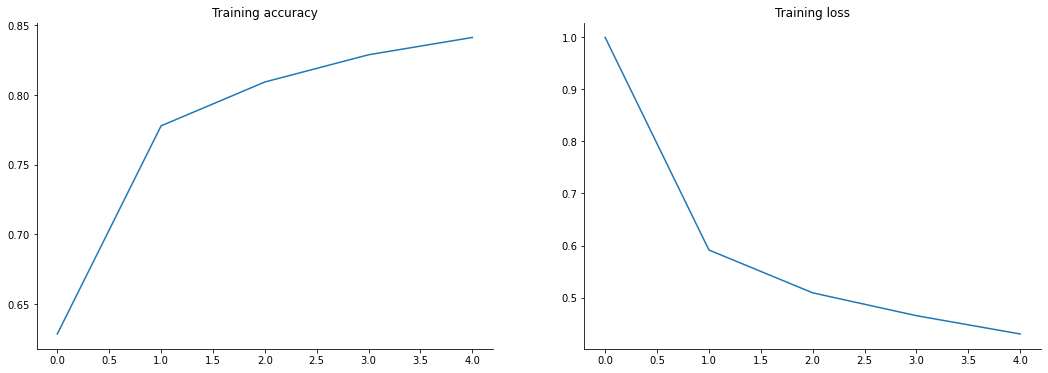

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(accuracy))

fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
axarr[0].plot(epochs, accuracy)
axarr[0].set_title('Training accuracy')
sns.despine()

axarr[1].plot(epochs, loss)
axarr[1].set_title('Training loss')
sns.despine()

plt.show()

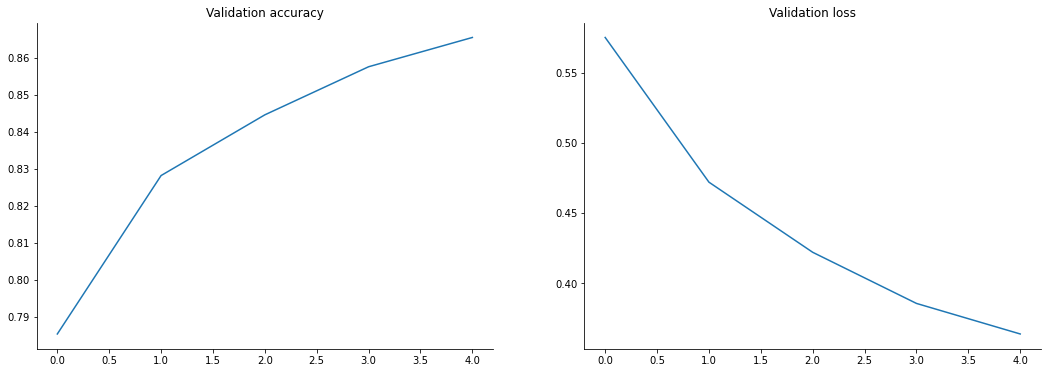

In [19]:
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(len(val_accuracy))

fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
axarr[0].plot(epochs, val_accuracy)
axarr[0].set_title('Validation accuracy')
sns.despine()

axarr[1].plot(epochs, val_loss)
axarr[1].set_title('Validation loss')
sns.despine()

plt.show()

In [20]:
y_test_pred = clf.predict_classes(X_test)
y_test_classed = np.nonzero(y_test)[1]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test_pred, y_test_classed, target_names=img_class_key.values()))

              precision    recall  f1-score   support

     t-shirt       0.80      0.83      0.82      1185
       pants       0.96      0.99      0.98      1145
    pullover       0.72      0.83      0.77      1051
       dress       0.92      0.85      0.88      1340
        coat       0.79      0.71      0.75      1308
      sandal       0.96      0.97      0.96      1131
       shirt       0.63      0.64      0.63      1240
    sneakers       0.95      0.95      0.95      1220
     handbag       0.97      0.97      0.97      1160
        boot       0.96      0.96      0.96      1220

    accuracy                           0.87     12000
   macro avg       0.87      0.87      0.87     12000
weighted avg       0.87      0.87      0.87     12000



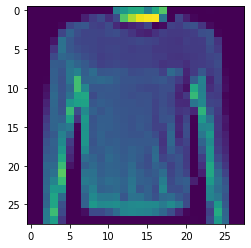

In [22]:
test_im = X_train[154]
plt.imshow(test_im.reshape(28,28), cmap='viridis', interpolation='none')
plt.show()

<ipython-input-23-2d9696d4a866>:23: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


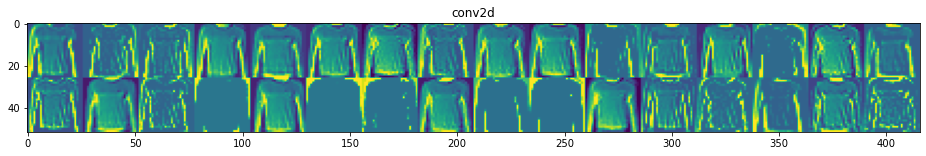

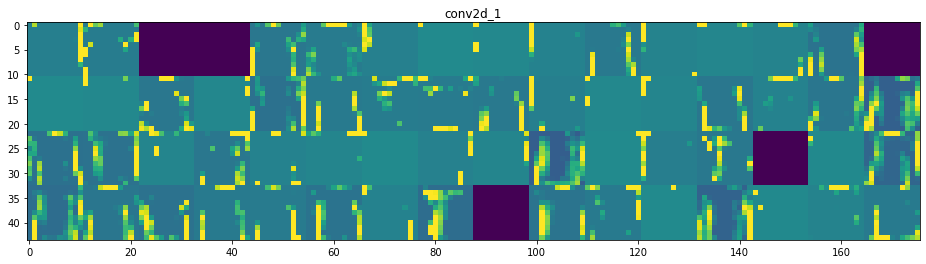

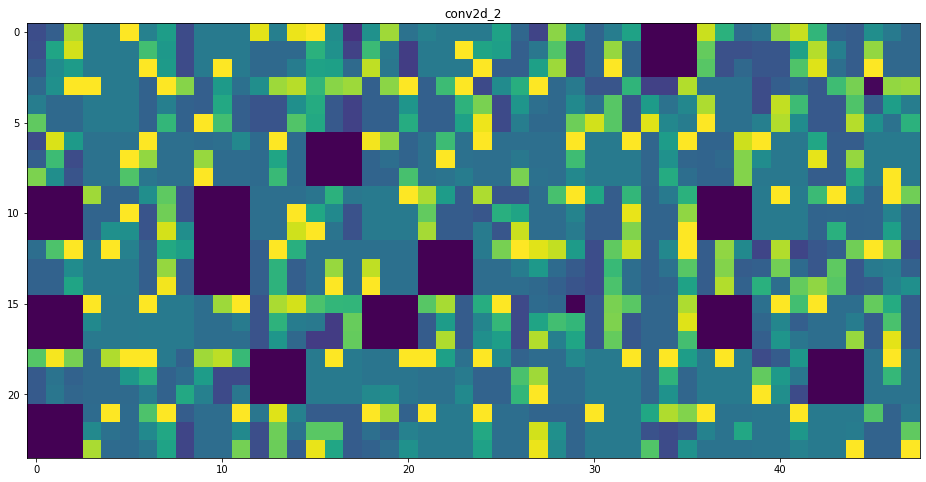

In [23]:
from keras import models
layer_outputs = [layer.output for layer in clf.layers[:8]]


#activatoin_model = models.Model()
activation_model = models.Model(inputs=clf.input, outputs=layer_outputs)
activations = activation_model.predict(test_im.reshape(1,28,28,1))

layer_names = []
for layer in clf.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [24]:
clf.save('clf.h5')

In [25]:
!tar -czvf clf.tar.gz clf.h5

a clf.h5


In [ ]:
!cp clf.tar.gz /opt/ml/model/clf.tar.gz